In [1]:
import numpy as np
import pickle
import math
import neuralnetworks_pytorch as nn
import picturegenerator as pg
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning Project to Predict Bits Of An Elliptic Curve Private Key

*by Robbie Weinel, May 14, 2019*

## Introduction

Elliptic Curve Diffie Hellman Symmetric key creation is a technique used in cryptography that allows two parties to generate a shared symmetric key without fear of a of man in the middle attack. The algorithm relies on a trap door function, making it incredible easy to solve the equation given some inputs, but near impossible to solve given a different set. To generate a shared symmetric key, you need to have your own public private elliptic key pair and know someone else's public key.  For example, say Alice and Bob want to communicate in secret. They each generate a key pair, using a publicly agreed upon function, starting position, and fingerprint. Then, they each publicly post their public key for the world to see. Now Alice can take her private key, and Bob’s public key, and generate a 3rd key from them. This key is her and Bob’s shared symmetric key. When Bob uses Alice’s public key, and his private key, he will get the same key, and they will now be able to communicate privately using their shared encryption. For more information on the exact process and security expectations, check out this video: https://youtu.be/Yjrfm_oRO0w.  

Now, with this understanding we can reasonably say that there exists some relationship between all the different keys.  What I want to see is if you can take advantage of that relationship and use a convolutional neural network to “predict” bits of another person's private key, given: their public key, our shared symmetric key, and my public and private keys. I made 3 distinct trials when attempting to do this, the first two proved to be unsuccessful, while the last attempt showed some promise. It would be foolish to assume that I have succeeded in cracking Diffie Hellman, but based on the results of the last test, it does seem like my method may have found a vulnerabiltiy. 

## Methods

Quick Rundown Of All Files And Purposes:
* Attempting To pred...ipynb - File used to test code segments related to the network aspects of the project. 
* PictureGenerator.ipynb - I used this file to test code segments related to generating the data.
* [AttemptNumber][cod/char][NumberofIts].txt - These files contain the console output from each different attempt.
* attempt[Number].tar.gz - These files contain the code, network, and data from each of the first 2 attempts, the 3rd attempt is located in the current directory.
* expshare.py - This is the main driver python script that handles generating and training the network.
* genKey.sh - This is called by the picture generator script to create a new set of public and private keys that will be converted into data to train on.
* neuralnetworks_pytorch.py - The code used for the network.
* picturegenerator.py - Python script used for data generation.
* test_[pub/priv]_key.pem - Key pair that is held constant for the entirety of the testing.
* testingdata[Number].npz - The testing files from the attempt 3.0 training session. The reason for the ten different files is explained in the results section.
* trainednetwork.pkl - The trained network object from attempt 3.0

The best way for me to explain my process is chronologically because I made many decisions and changes as I uncovered new information. The first problem that I needed to solve was how to represent all the information to the network. When I first started this project, I was under the preconception that convolutional networks used image files, and that I was limited to 3 channels because of it. So, the first steps I took were to create an image generation program. This program originally took the output file's base name and number of pictures as its arguments. It would then create that many pictures in the directory it was ran in, all named with the base name and iteration number. The format of the picture was that each channel was represented by a different key, and each pixel correlated to a bit of the key. The red channel was the shared symmetric key, the green channel was my public and private keys, and the blue channel was the public key that pairs with the private key I was trying to predict. I used the torch code from class to generate and train my network, and it wasn’t until I went to start training that I learned that the exact format of the data that the network trains on is just a multi-dimensional NumPy array. It was a pretty easy fix to format the data this way, my program now just used the NumPy.save function to serialize the keys as npz files that could then be loaded and used as training data. It was then when I also learned that the network could handle as many channels as I want, I just needed to format everything properly. I was eager to start training though, so I did not change my picture setup and instead trained a 1 convolutional layer, 3 channels, network on 500,000 different keys. The network took a 64x64 “picture” as an input and had a 16-node array as its output. The network was set up to attempt to predict the last 4 bits of the private key giving it a 6.25% chance to randomly guess correctly.  Because I can generate my own unique data, I assumed that it was best to only ever show the network every key once and thus set the network to only train with one epoch. I later changed this to 5 epochs because it seemed like the network was not properly updating the weights.  Needless to say, my first attempt was not successful. To see the exact network configuration that I ran during the trial, check out the attempt1.tar.gz folder, the network was generated using the code in the “Attempting to predict...” notebook.  

For my second attempt I changed the network to handle 4 channels. This allowed me to cut down the input data to 32x32 “pictures”.  I also increased the number of hidden nodes and epochs.  Other than that, this attempt was very similar to the first attempt, and equally as unsuccessful. It can be found in attempt2.tar.gz. 

For my third and final attempt, I decided to ratchet up the network and code. The code now spawns a network on its own if no network file is found. It also has a numits.pkl file to store the number of iterations that the network has currently been trained on. The purpose of this file was to track the overall number of keys that the network had seen. I expected that the network would need to be trained on many different machines, for millions of total iterations before seeing any success. The new network for attempt 3 had 4 convolutional layers instead of just 1, and 4 output nodes (so I'd attempt to predict the last 2 bits of each private key) instead of 16. By simplifying the output and adding depth to the network, I hoped to be able to have a better chance at cracking this encryption. After training this network for only 50000 iterations it was able to correctly predict bits given the testing data 100% of the time. While this is exciting, there could be underlying factors that have to do with why this network was so much more successful than the other two, and I will discuss those in more detail in the conclusion section.  

## Results

Note: To increase efficiency, I trained my networks on the cod and char lab machines with the gpu flag set to true. If you want to run all the code cells you will need to have a CUDA enabled machine. On top of that I serialize and load my data with the pickle library. Inconsistencies in library versions could also cause issues with loading the network and associated data, if you encounter these problems its best to just train your own network in an attempt to replicate my results. To do so, delete the trainednetwork.pkl and numits.pkl file from your directory. Then run the command “python ./expshare.py [NumIterations] 

By looking at the different console outputs you can see the general success of the networks during their training sessions. Each training session was broken into 10 different iterations to save memory. If I had a npz training file with all 500000 of the key data points it would be over 7 gb and it would automatically be deleted by the school’s system. So, my expshare.py file separates the training into 10 batches. The data from the first attempt is unavailable because I didn’t think to write the console output to a file until the second attempt.  That being said, from the data available to me in the attempt1.tar.gz file, it can be seen that the network did not have a success rate greater than 10% for any of the testing files. As seen in the output from attempt 2, it also did not have any success greater than 10%. The networks for the first two attempts were fairly shallow, so it does not come as a surprise that the trials were unsuccessful. The percent compelete lines come from the picture generator script. Using the tee command I was able to view output while still writing it to the text file, so I included it as a way to track progress.  

In [1]:
#Printing the console output from attempt 2
!cat 2_cod_500000.txt

0.0 percent complete
10.0 percent complete
20.0 percent complete
30.0 percent complete
40.0 percent complete
50.0 percent complete
60.0 percent complete
70.0 percent complete
80.0 percent complete
90.0 percent complete
0.0 percent complete
10.0 percent complete
20.0 percent complete
30.0 percent complete
40.0 percent complete
50.0 percent complete
60.0 percent complete
70.0 percent complete
80.0 percent complete
90.0 percent complete
Iteration 1, cost = 2.8010, acc = 6.22
Iteration 2, cost = 2.7956, acc = 6.22
Iteration 3, cost = 2.7955, acc = 6.22
Iteration 4, cost = 2.7955, acc = 6.22
Iteration 5, cost = 2.7955, acc = 6.22
Final Run Of Testing Data: 6.22
0.0 percent complete
10.0 percent complete
20.0 percent complete
30.0 percent complete
40.0 percent complete
50.0 percent complete
60.0 percent complete
70.0 percent complete
80.0 percent complete
90.0 percent complete
0.0 percent complete
10.0 percent complete
20.0 percent complete
30.0 percent complete
40.0 percent complete
50.0 pe

Attempt 3 is where the network starts to produce real results. As you can see from the console output, although it was only trained on 100000 different keys, it was able to succesfully predict the last two bits of the private key 100% of the time. On top of that it does so in only 10000 iterations. 

In [7]:
#Printing console output from attempt 3.0
!cat 3.0_char_100000.txt

Creating Neural Network
NeuralNetworkClassifier_Pytorch created on cuda
Iteration 1, cost = 0.4031, acc = 100.00
Iteration 2, cost = 0.0077, acc = 100.00
Iteration 3, cost = 0.0031, acc = 100.00
Iteration 4, cost = 0.0017, acc = 100.00
Iteration 5, cost = 0.0010, acc = 100.00
Final Run Of Testing Data: 100.0
0.0 percent complete
10.0 percent complete
20.0 percent complete
30.0 percent complete
40.0 percent complete
50.0 percent complete
60.0 percent complete
70.0 percent complete
80.0 percent complete
90.0 percent complete
(10000, 4, 32, 32)
0.0 percent complete
10.0 percent complete
20.0 percent complete
30.0 percent complete
40.0 percent complete
50.0 percent complete
60.0 percent complete
70.0 percent complete
80.0 percent complete
90.0 percent complete
(1000, 4, 32, 32)
Iteration 1, cost = 0.0004, acc = 100.00
Iteration 2, cost = 0.0001, acc = 100.00
Iteration 3, cost = 0.0001, acc = 100.00
Iteration 4, cost = 0.0000, acc = 100.00
Iteration 5, cost = 0.0000, acc = 100.00
Final Run 

After seeing the success of the new model, I decided to redo the test, but this time with less iterations. That way I could see the growth better. The console output from the test can be found in 3.1_char_50000.txt. 

In [8]:
#Printing console output from attempt 3.1
!cat 3.1_char_50000.txt

Creating Neural Network
NeuralNetworkClassifier_Pytorch created on cuda
0.0 percent complete
10.0 percent complete
20.0 percent complete
30.0 percent complete
40.0 percent complete
50.0 percent complete
60.0 percent complete
70.0 percent complete
80.0 percent complete
90.0 percent complete
(500, 4, 32, 32)
0.0 percent complete
10.0 percent complete
20.0 percent complete
30.0 percent complete
40.0 percent complete
50.0 percent complete
60.0 percent complete
70.0 percent complete
80.0 percent complete
90.0 percent complete
(50, 4, 32, 32)
Iteration 1, cost = 1.4987, acc = 22.00
Iteration 2, cost = 1.4030, acc = 22.00
Iteration 3, cost = 1.3549, acc = 22.00
Iteration 4, cost = 1.3207, acc = 16.00
Iteration 5, cost = 1.2201, acc = 22.00
Final Run Of Testing Data: 22.0
0.0 percent complete
10.0 percent complete
20.0 percent complete
30.0 percent complete
40.0 percent complete
50.0 percent complete
60.0 percent complete
70.0 percent complete
80.0 percent complete
90.0 percent complete
(500, 

The final accuracy of the network after every 5000 new keys can be seen on lines that start with Final. Parsing those lines allows me to graph the results.

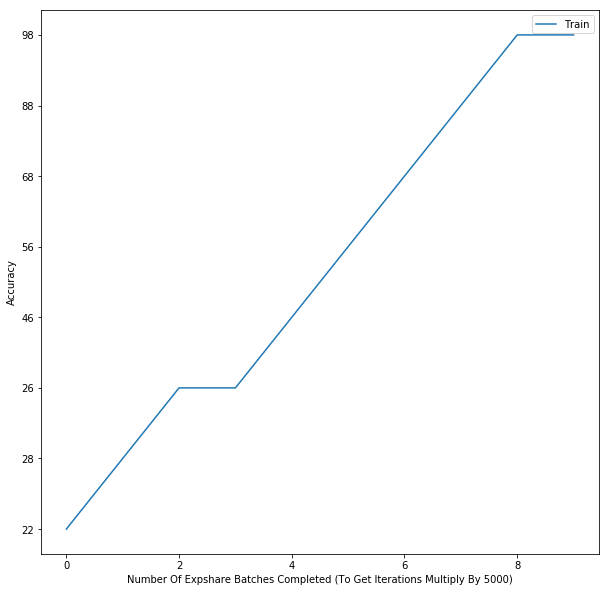

In [30]:
f = open("3.1_char_50000.txt", "r")
ray = []
for line in f:
    if(line[0] == 'F'):
       ray.append((line[27:29]))
plt.figure(figsize=(10, 10))
plt.plot(np.array(ray))
plt.legend(('Train','Test'))
plt.xlabel('Number Of Expshare Batches Completed (To Get Iterations Multiply By 5000)')
plt.ylabel('Accuracy'); 

In [4]:
def percent_correct(actual, predicted):
    return 100 * np.mean(actual == predicted)

In [2]:
#To Load And Test The Network Yourself Run These Code Cells
npzfile = np.load('testingdata0.npz')
Xtest = npzfile['data']
Ttest = npzfile['answers']
(Xtest.shape, Ttest.shape)

((5000, 4, 32, 32), (5000,))

In [5]:
nnet = pickle.load ( open( "trainednet.pkl", "rb"))
classes, probs, y = nnet.use(Xtest)
(percent_correct(Ttest, classes))

100.0

To generate and run your own network, rename the .pkl files and run:
    

In [35]:
#This Cell Will Overwrite Data, Run With Causion
#!python ./expshare.py 50000

## Conclusions

After all of the trial and error, three attempts, and almost a hundred total hours of training, I was able to prove my hypothesis. You can in fact use a convolutional neural network to predict the last 2 bits of a private key when given: the keys corrisponding public key, another pair or keys that the network has been trained with, and the shared symmetric key generated from the two sets.  There are still many steps to be taken before I can state with full certainty that there is a vulnerabilty in Diffie Hellman key generation. There are many factors that could have interfered with my experiments and thus devalued my results. As a simple example, it could be that the last two bits of the key are independent from the rest and serve only as a check sum. Those last two bits could also be easier to calculate than any of the others. There may even exist no relation at all for some of the other bits. There are thousands of ways that my results could be a stroke of luck, and when you can find success for such a complicated procedure with just 50,000 training iterations it definitively raises some red flags. Moving forward, what I would like to do is create a network for every set of 2 bits for the keys. If I am successful with that, I will build a script to compile all of the different networks and use them to crack keys. I have a lot of work to do, but overall I am very thankful that this class gave me the knowlege, opportunity, and ability to experiment with my own research. 

### References

* [Goodfellow, et al., 2016] Ian Goodfellow and Yoshua Bengio and Aaron Courville, [Deep Learning](http://www.deeplearningbook.org), MIT Press. 2014.
* https://jameshfisher.com/2017/04/14/openssl-ecc/
* https://wiki.openssl.org/index.php/Command_Line_Elliptic_Curve_Operations

Your report for a single person team should contain approximately 2,000 to 5,000 words, in markdown cells.  You can count words by running the following python code in your report directory.  Projects with two people, for example, should contain 4,000 to 8,000 words.

In [9]:
import io
from IPython.nbformat import current
import glob
nbfile = glob.glob('Weinel_Final_Report.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file Weinel_Final_Report.ipynb is 2043
